In [1]:
# 步骤一：导入相关库
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
# 步骤二：加载数据集
# 2.1 设置超参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.003
DOWNLOAD_CIFAR = False
DEVICE = 'mps'
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2023, 0.1994, 0.2010]

# 2.2 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std),
])

# 2.3 检查是否需要下载数据集
if not (os.path.exists('./cifar/')) or not os.listdir('./cifar/'):
    DOWNLOAD_CIFAR = True

# 2.4 加载训练集和测试集
train_data = torchvision.datasets.CIFAR10(
    root='./cifar/',
    train=True,
    transform=transform,
    download=DOWNLOAD_CIFAR
)
test_data = torchvision.datasets.CIFAR10(
    root='./cifar/',
    train=False,
    transform=transform,
    download=DOWNLOAD_CIFAR
)

# 2.5 封装数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=16
)
test_loader = Data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=16
)

In [3]:
# 步骤三：CNN模型设计
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 8 * 8, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=10)
        )

    def forward(self, x):
        x = self.conv(x)
        output = self.fc(x)
        return output


# 3.2 实例化模型并迁移到设备
cnn = CNN().to(DEVICE)
print(cnn)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [4]:
# 步骤四：设置损失函数与优化器
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [5]:
# 步骤五：训练模型
train_losses = []
test_accuracies = []


# 5.1 定义训练函数
def train(epoch):
    cnn.train()
    epoch_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx > 0 and batch_idx % 100 == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Current Avg Loss: {epoch_loss / (batch_idx + 1):.4f}')

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}] Average Train Loss: {avg_epoch_loss:.4f}")


# 5.2 定义测试函数（返回 acc，预测标签，真实标签）
def test():
    cnn.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = cnn(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_preds.append(predicted.cpu())
            all_labels.append(targets.cpu())

    # 计算准确率（百分比形式）
    acc = 100. * correct / total
    pred_y = torch.cat(all_preds)
    true_y = torch.cat(all_labels)
    return acc, pred_y, true_y


# 5.3 开始训练过程
os.makedirs('./output', exist_ok=True)

for epoch in range(EPOCH):
    train(epoch)
    acc, _, _ = test()
    test_accuracies.append(acc)
    print(f"Test Accuracy after Epoch [{epoch+1}]: {acc:.2f}%")

Training Epoch 1:  13%|█▎        | 104/782 [01:44<00:30, 21.97it/s]  

  Batch 100/782, Current Avg Loss: 2.4879


Training Epoch 1:  27%|██▋       | 212/782 [02:37<00:21, 26.82it/s]

  Batch 200/782, Current Avg Loss: 2.1867


Training Epoch 1:  40%|███▉      | 310/782 [02:39<00:08, 52.46it/s]

  Batch 300/782, Current Avg Loss: 2.0553


Training Epoch 1:  52%|█████▏    | 405/782 [02:41<00:10, 34.40it/s]

  Batch 400/782, Current Avg Loss: 1.9792


Training Epoch 1:  65%|██████▌   | 509/782 [02:44<00:06, 41.89it/s]

  Batch 500/782, Current Avg Loss: 1.9251


Training Epoch 1:  78%|███████▊  | 609/782 [02:46<00:04, 41.29it/s]

  Batch 600/782, Current Avg Loss: 1.8777


Training Epoch 1:  91%|█████████ | 713/782 [02:48<00:01, 63.11it/s]

  Batch 700/782, Current Avg Loss: 1.8397


Training Epoch 1: 100%|██████████| 782/782 [07:13<00:00,  1.81it/s]


Epoch [1] Average Train Loss: 1.8147


Testing: 100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


Test Accuracy after Epoch [1]: 46.70%


Training Epoch 2:  15%|█▍        | 115/782 [00:21<00:15, 42.84it/s]

  Batch 100/782, Current Avg Loss: 1.5667


Training Epoch 2:  29%|██▊       | 223/782 [00:21<00:05, 106.59it/s]

  Batch 200/782, Current Avg Loss: 1.5301


Training Epoch 2:  41%|████      | 319/782 [00:22<00:04, 114.40it/s]

  Batch 300/782, Current Avg Loss: 1.5181


Training Epoch 2:  53%|█████▎    | 415/782 [00:23<00:03, 116.37it/s]

  Batch 400/782, Current Avg Loss: 1.4998


Training Epoch 2:  67%|██████▋   | 523/782 [00:24<00:02, 118.01it/s]

  Batch 500/782, Current Avg Loss: 1.4865


Training Epoch 2:  79%|███████▉  | 619/782 [00:25<00:01, 115.43it/s]

  Batch 600/782, Current Avg Loss: 1.4751


Training Epoch 2:  91%|█████████▏| 715/782 [00:26<00:00, 114.81it/s]

  Batch 700/782, Current Avg Loss: 1.4636


Training Epoch 2: 100%|██████████| 782/782 [01:46<00:00,  7.32it/s] 


Epoch [2] Average Train Loss: 1.4531


Testing: 100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Test Accuracy after Epoch [2]: 58.91%


Training Epoch 3:  15%|█▌        | 118/782 [00:21<00:11, 56.08it/s]

  Batch 100/782, Current Avg Loss: 1.3274


Training Epoch 3:  28%|██▊       | 222/782 [00:22<00:05, 105.63it/s]

  Batch 200/782, Current Avg Loss: 1.3084


Training Epoch 3:  41%|████      | 317/782 [00:23<00:04, 110.34it/s]

  Batch 300/782, Current Avg Loss: 1.3096


Training Epoch 3:  53%|█████▎    | 413/782 [00:24<00:03, 112.89it/s]

  Batch 400/782, Current Avg Loss: 1.2977


Training Epoch 3:  67%|██████▋   | 521/782 [00:25<00:02, 108.26it/s]

  Batch 500/782, Current Avg Loss: 1.2915


Training Epoch 3:  79%|███████▊  | 614/782 [00:26<00:01, 106.60it/s]

  Batch 600/782, Current Avg Loss: 1.2814


Training Epoch 3:  92%|█████████▏| 718/782 [00:27<00:00, 109.47it/s]

  Batch 700/782, Current Avg Loss: 1.2768


Training Epoch 3: 100%|██████████| 782/782 [01:47<00:00,  7.26it/s] 


Epoch [3] Average Train Loss: 1.2705


Testing: 100%|██████████| 157/157 [01:35<00:00,  1.64it/s]


Test Accuracy after Epoch [3]: 62.65%


Training Epoch 4:  16%|█▌        | 123/782 [00:21<00:12, 52.37it/s]

  Batch 100/782, Current Avg Loss: 1.2083


Training Epoch 4:  28%|██▊       | 219/782 [00:22<00:05, 108.13it/s]

  Batch 200/782, Current Avg Loss: 1.2000


Training Epoch 4:  40%|████      | 315/782 [00:23<00:04, 114.45it/s]

  Batch 300/782, Current Avg Loss: 1.1863


Training Epoch 4:  54%|█████▍    | 423/782 [00:24<00:03, 115.44it/s]

  Batch 400/782, Current Avg Loss: 1.1726


Training Epoch 4:  66%|██████▋   | 519/782 [00:24<00:02, 115.08it/s]

  Batch 500/782, Current Avg Loss: 1.1749


Training Epoch 4:  79%|███████▊  | 615/782 [00:25<00:01, 114.54it/s]

  Batch 600/782, Current Avg Loss: 1.1703


Training Epoch 4:  92%|█████████▏| 723/782 [00:26<00:00, 113.78it/s]

  Batch 700/782, Current Avg Loss: 1.1656


Training Epoch 4: 100%|██████████| 782/782 [01:47<00:00,  7.29it/s] 


Epoch [4] Average Train Loss: 1.1630


Testing: 100%|██████████| 157/157 [01:34<00:00,  1.65it/s]


Test Accuracy after Epoch [4]: 66.38%


Training Epoch 5:  15%|█▍        | 114/782 [00:21<00:15, 42.55it/s]

  Batch 100/782, Current Avg Loss: 1.0689


Training Epoch 5:  29%|██▊       | 223/782 [00:22<00:05, 109.80it/s]

  Batch 200/782, Current Avg Loss: 1.0651


Training Epoch 5:  41%|████      | 319/782 [00:23<00:04, 112.27it/s]

  Batch 300/782, Current Avg Loss: 1.0658


Training Epoch 5:  53%|█████▎    | 415/782 [00:23<00:03, 116.56it/s]

  Batch 400/782, Current Avg Loss: 1.0720


Training Epoch 5:  67%|██████▋   | 523/782 [00:24<00:02, 112.26it/s]

  Batch 500/782, Current Avg Loss: 1.0696


Training Epoch 5:  79%|███████▉  | 619/782 [00:25<00:01, 113.68it/s]

  Batch 600/782, Current Avg Loss: 1.0659


Training Epoch 5:  91%|█████████▏| 715/782 [00:26<00:00, 115.21it/s]

  Batch 700/782, Current Avg Loss: 1.0637


Training Epoch 5: 100%|██████████| 782/782 [01:47<00:00,  7.30it/s] 


Epoch [5] Average Train Loss: 1.0655


Testing: 100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Test Accuracy after Epoch [5]: 69.03%


Training Epoch 6:  15%|█▍        | 116/782 [00:22<00:13, 49.31it/s]

  Batch 100/782, Current Avg Loss: 1.0035


Training Epoch 6:  29%|██▊       | 224/782 [00:22<00:05, 110.58it/s]

  Batch 200/782, Current Avg Loss: 1.0001


Training Epoch 6:  41%|████      | 320/782 [00:23<00:03, 115.86it/s]

  Batch 300/782, Current Avg Loss: 0.9961


Training Epoch 6:  53%|█████▎    | 416/782 [00:24<00:03, 105.79it/s]

  Batch 400/782, Current Avg Loss: 1.0003


Training Epoch 6:  66%|██████▌   | 516/782 [00:25<00:02, 107.80it/s]

  Batch 500/782, Current Avg Loss: 1.0045


Training Epoch 6:  80%|███████▉  | 622/782 [00:26<00:01, 114.61it/s]

  Batch 600/782, Current Avg Loss: 1.0060


Training Epoch 6:  92%|█████████▏| 718/782 [00:27<00:00, 111.55it/s]

  Batch 700/782, Current Avg Loss: 1.0061


Training Epoch 6: 100%|██████████| 782/782 [01:47<00:00,  7.24it/s] 


Epoch [6] Average Train Loss: 1.0039


Testing: 100%|██████████| 157/157 [01:35<00:00,  1.64it/s]


Test Accuracy after Epoch [6]: 70.10%


Training Epoch 7:  14%|█▍        | 113/782 [00:22<00:16, 41.11it/s]

  Batch 100/782, Current Avg Loss: 0.9089


Training Epoch 7:  28%|██▊       | 221/782 [00:23<00:05, 107.33it/s]

  Batch 200/782, Current Avg Loss: 0.9237


Training Epoch 7:  41%|████      | 317/782 [00:24<00:04, 113.79it/s]

  Batch 300/782, Current Avg Loss: 0.9296


Training Epoch 7:  53%|█████▎    | 413/782 [00:24<00:03, 114.40it/s]

  Batch 400/782, Current Avg Loss: 0.9396


Training Epoch 7:  67%|██████▋   | 521/782 [00:25<00:02, 111.37it/s]

  Batch 500/782, Current Avg Loss: 0.9456


Training Epoch 7:  79%|███████▊  | 615/782 [00:26<00:01, 112.54it/s]

  Batch 600/782, Current Avg Loss: 0.9500


Training Epoch 7:  92%|█████████▏| 723/782 [00:27<00:00, 113.40it/s]

  Batch 700/782, Current Avg Loss: 0.9467


Training Epoch 7: 100%|██████████| 782/782 [01:48<00:00,  7.23it/s] 


Epoch [7] Average Train Loss: 0.9491


Testing: 100%|██████████| 157/157 [01:35<00:00,  1.64it/s]


Test Accuracy after Epoch [7]: 70.99%


Training Epoch 8:  14%|█▍        | 113/782 [00:21<00:13, 49.80it/s]

  Batch 100/782, Current Avg Loss: 0.8656


Training Epoch 8:  27%|██▋       | 215/782 [00:22<00:05, 104.42it/s]

  Batch 200/782, Current Avg Loss: 0.8823


Training Epoch 8:  41%|████▏     | 323/782 [00:23<00:03, 116.69it/s]

  Batch 300/782, Current Avg Loss: 0.8880


Training Epoch 8:  54%|█████▎    | 419/782 [00:24<00:03, 116.76it/s]

  Batch 400/782, Current Avg Loss: 0.8885


Training Epoch 8:  66%|██████▌   | 515/782 [00:25<00:02, 114.58it/s]

  Batch 500/782, Current Avg Loss: 0.8893


Training Epoch 8:  80%|███████▉  | 623/782 [00:26<00:01, 115.89it/s]

  Batch 600/782, Current Avg Loss: 0.8929


Training Epoch 8:  92%|█████████▏| 719/782 [00:26<00:00, 111.99it/s]

  Batch 700/782, Current Avg Loss: 0.8957


Training Epoch 8: 100%|██████████| 782/782 [01:47<00:00,  7.27it/s] 


Epoch [8] Average Train Loss: 0.8969


Testing: 100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Test Accuracy after Epoch [8]: 72.31%


Training Epoch 9:  14%|█▍        | 113/782 [00:21<00:15, 42.32it/s]

  Batch 100/782, Current Avg Loss: 0.8417


Training Epoch 9:  28%|██▊       | 221/782 [00:22<00:05, 110.36it/s]

  Batch 200/782, Current Avg Loss: 0.8480


Training Epoch 9:  41%|████      | 317/782 [00:23<00:04, 115.35it/s]

  Batch 300/782, Current Avg Loss: 0.8488


Training Epoch 9:  54%|█████▍    | 421/782 [00:24<00:03, 106.10it/s]

  Batch 400/782, Current Avg Loss: 0.8528


Training Epoch 9:  66%|██████▌   | 517/782 [00:25<00:02, 102.91it/s]

  Batch 500/782, Current Avg Loss: 0.8587


Training Epoch 9:  79%|███████▉  | 620/782 [00:26<00:01, 110.48it/s]

  Batch 600/782, Current Avg Loss: 0.8582


Training Epoch 9:  92%|█████████▏| 716/782 [00:27<00:00, 115.94it/s]

  Batch 700/782, Current Avg Loss: 0.8584


Training Epoch 9: 100%|██████████| 782/782 [01:47<00:00,  7.27it/s] 


Epoch [9] Average Train Loss: 0.8597


Testing: 100%|██████████| 157/157 [01:35<00:00,  1.65it/s]


Test Accuracy after Epoch [9]: 72.12%


Training Epoch 10:  15%|█▍        | 114/782 [00:21<00:15, 42.52it/s]

  Batch 100/782, Current Avg Loss: 0.7953


Training Epoch 10:  28%|██▊       | 222/782 [00:22<00:05, 107.66it/s]

  Batch 200/782, Current Avg Loss: 0.8089


Training Epoch 10:  41%|████      | 318/782 [00:22<00:04, 110.17it/s]

  Batch 300/782, Current Avg Loss: 0.8117


Training Epoch 10:  53%|█████▎    | 414/782 [00:23<00:03, 114.42it/s]

  Batch 400/782, Current Avg Loss: 0.8117


Training Epoch 10:  67%|██████▋   | 522/782 [00:24<00:02, 114.99it/s]

  Batch 500/782, Current Avg Loss: 0.8128


Training Epoch 10:  79%|███████▉  | 618/782 [00:25<00:01, 115.02it/s]

  Batch 600/782, Current Avg Loss: 0.8179


Training Epoch 10:  91%|█████████▏| 714/782 [00:26<00:00, 115.34it/s]

  Batch 700/782, Current Avg Loss: 0.8211


Training Epoch 10: 100%|██████████| 782/782 [01:47<00:00,  7.31it/s] 


Epoch [10] Average Train Loss: 0.8238


Testing: 100%|██████████| 157/157 [01:35<00:00,  1.65it/s]

Test Accuracy after Epoch [10]: 72.48%


Testing: 100%|██████████| 157/157 [01:35<00:00,  1.64it/s]



Final Test Accuracy: 72.48%


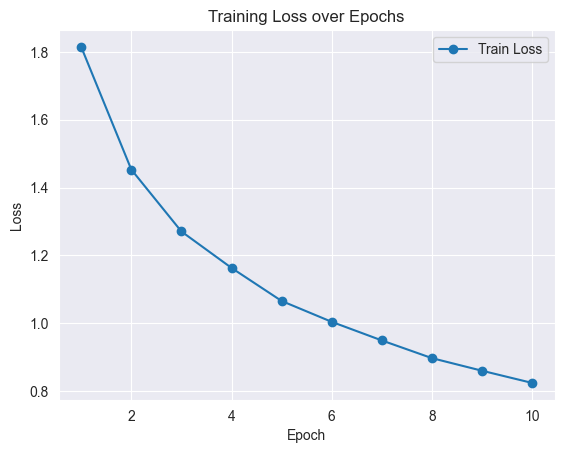

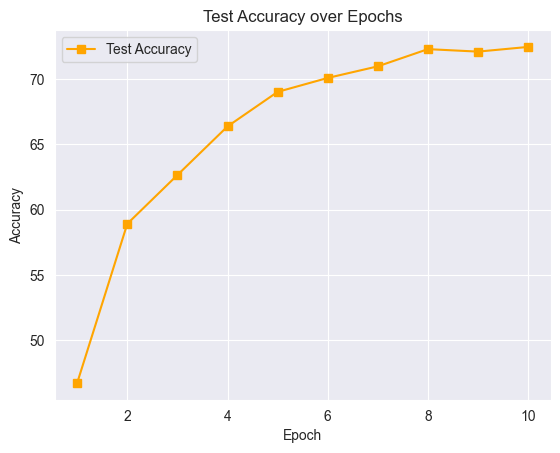

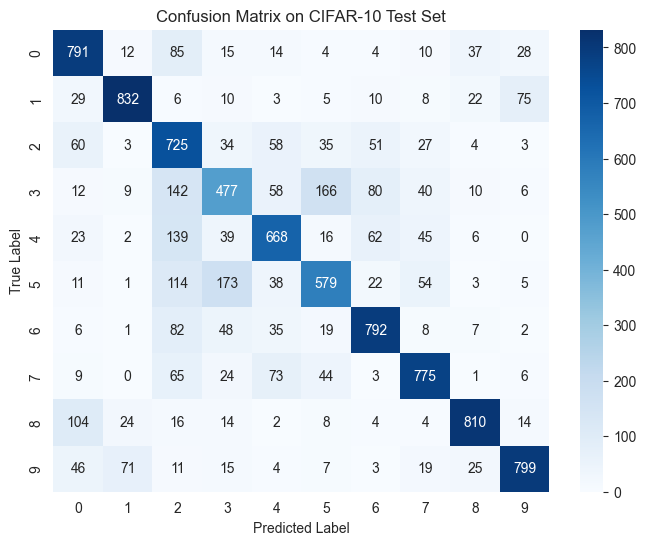

Prediction: [3 8 0 0 6 6 1 6 3 1]
Actual:     [3 8 8 0 6 6 1 6 3 1]


In [7]:
# 步骤六：模型评估
# 6.1 最后一次测试
final_acc, pred_y, true_y = test()
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

# 6.2 绘制训练loss变化曲线
plt.figure()
plt.plot(range(1, EPOCH + 1), train_losses, marker='o', label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('./output/train_loss_curve.png')
plt.show()

# 6.3 绘制测试准确率变化曲线
plt.figure()
plt.plot(range(1, EPOCH + 1), test_accuracies, marker='s', color='orange', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('./output/test_accuracy_curve.png')
plt.show()

# 6.4 绘制混淆矩阵
conf_mat = confusion_matrix(true_y.numpy(), pred_y.numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on CIFAR-10 Test Set")
plt.savefig('./output/confusion_matrix.png')
plt.show()

# 6.5 打印前10个预测结果
print('Prediction:', pred_y[:10].numpy())
print('Actual:    ', true_y[:10].numpy())

In [8]:
# 步骤七：保存模型与结果
torch.save(cnn.state_dict(), './output/cifar10_cnn_model.pth')
print("Model saved to ./output/cifar10_cnn_model.pth")

Model saved to ./output/cifar10_cnn_model.pth


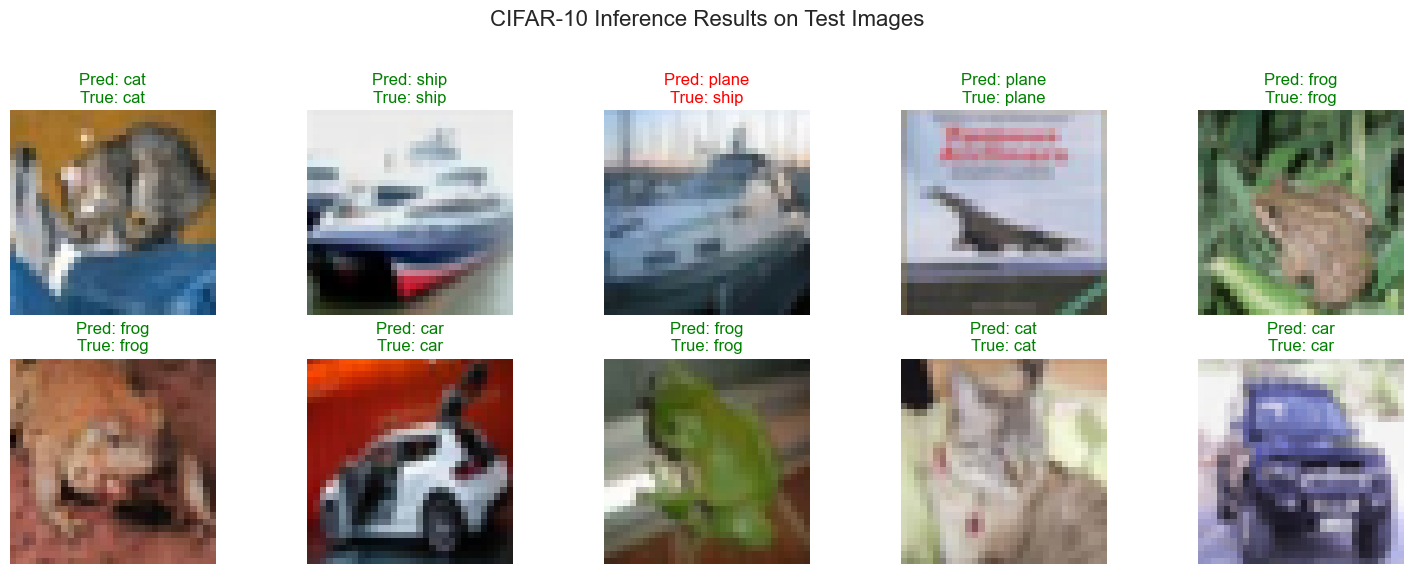

In [9]:
# 步骤八：推理结果可视化
# 8.1 CIFAR10 类别标签
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


# 8.2 可视化推理函数
def visualize_cifar10_predictions(model, test_loader, device='mps', num_images=10):
    """
    可视化模型在 CIFAR-10 测试集上的部分预测结果（RGB 彩色图）
    """
    model.eval()
    shown = 0
    plt.figure(figsize=(15, 6))

    mean = torch.tensor(cifar10_mean, device=device).view(3, 1, 1)
    std = torch.tensor(cifar10_std, device=device).view(3, 1, 1)

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if shown >= num_images:
                    break

                # 提取第 i 张图像并反归一化
                img_tensor = inputs[i]
                img_tensor = img_tensor * std + mean
                img_tensor = torch.clamp(img_tensor, 0, 1)
                img = img_tensor.cpu().permute(1, 2, 0).numpy()

                true_label = classes[targets[i].item()]
                pred_label = classes[predicted[i].item()]

                plt.subplot(2, (num_images + 1) // 2, shown + 1)
                plt.imshow(img)
                color = "green" if pred_label == true_label else "red"
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
                plt.axis('off')
                shown += 1

            if shown >= num_images:
                break

    plt.suptitle("CIFAR-10 Inference Results on Test Images", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./output/cifar10_test_predictions.png')
    plt.show()


# 8.3 执行推理可视化
visualize_cifar10_predictions(cnn, test_loader, device=DEVICE, num_images=10)